In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

In [2]:
''' The following shows the result of training various non-nerual network models on a original version of the 
Kannada set. models are trained on an tf-idf vectorizer
with dimensionality reduction.'''

' The following shows the result of training various non-nerual network models on a original version of the \nKannada set. models are trained on an tf-idf vectorizer\nwith dimensionality reduction.'

In [3]:
# import data
kan_train = pd.read_table("../../datasets/task_a/kan_sentiment_train.tsv")
kan_dev = pd.read_table("../../datasets/task_a/kan_sentiment_dev.tsv")

In [4]:
kan_train = kan_train.rename(columns={'category': 'y'})
kan_dev = kan_dev.rename(columns={'category': 'y'})

In [5]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


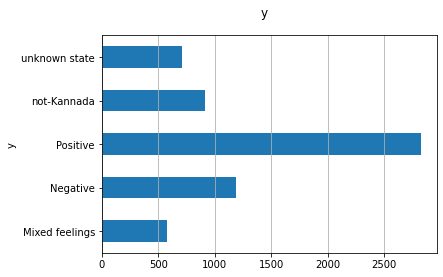

In [6]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
kan_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [7]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


In [8]:
# Now we can define our training data and our dev data as well as targets
train = kan_train
test = kan_dev

y_train = kan_train['y'].values
y_test = kan_dev['y'].values


## Using Tf-Idf vectorizer

In [10]:
## Count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [11]:
# now run thse vectorizers on the train data
corpus = train["text"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [12]:
X_train

<6212x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 46088 stored elements in Compressed Sparse Row format>

Text(0.5, 1.0, 'Sparse Matrix Sample')

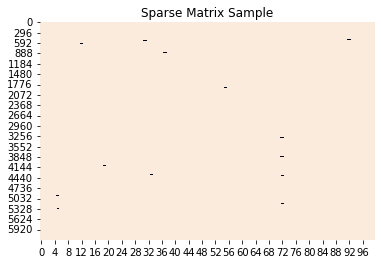

In [13]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

## reducing the vectorizers dimensionality

In [14]:
# reduce dimensionality through feature selection

y = y_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [15]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# Mixed feelings:
  . selected features: 322
  . top features: game,yava game,game name,yavadu,game yavdu,bro game,ಅದ ಪದ,bigg boss,32,game yavadu
 
# Negative:
  . selected features: 342
  . top features: nandi,nandi parthasarathi,parthasarathi,super,dislike,sule,nan,rashmika,gandu,prithvi nayak
 
# Positive:
  . selected features: 129
  . top features: ಪರ,ಗಡ ಇದ,ದನ ಗಡ,ಗಡ,ಇದ,ದನ,ಚರ,ಗರ,parthasarathi,nandi
 
# not-Kannada:
  . selected features: 324
  . top features: super,super bro,super song,anjali devi,devi,anjali,bro,song,super super,nice
 
# unknown state:
  . selected features: 310
  . top features: yes,gta,gta bro,paramvah,paramvah music,lokanath,join,yes bro,like,godiyaga
 


## re-fitting the vectorizer on the new vocabulary gained through feature reduction

In [16]:
# we can now refit the vecotrizer on the corpus by giving this new set of words as input.
# producing a smaller feature matrix and a shorter vocabulary.
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_


In [17]:
X_train.shape

(6212, 1331)

Text(0.5, 1.0, 'Sparse Matrix Sample')

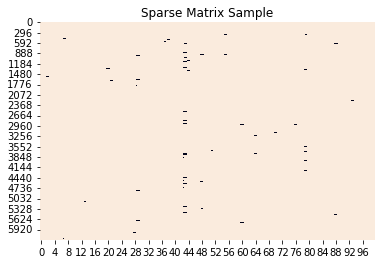

In [18]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

# Training a Naive Bayes Classifier

In [19]:
# Now we can train a model. i'm using a naive bayes classifier
classifier = naive_bayes.MultinomialNB()

In [20]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.57
Auc: 0.8
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.67      0.04      0.07        52
      Negative       0.63      0.45      0.52       139
      Positive       0.55      0.92      0.69       321
   not-Kannada       0.66      0.25      0.36       110
 unknown state       0.46      0.09      0.15        69

      accuracy                           0.57       691
     macro avg       0.59      0.35      0.36       691
  weighted avg       0.58      0.57      0.50       691



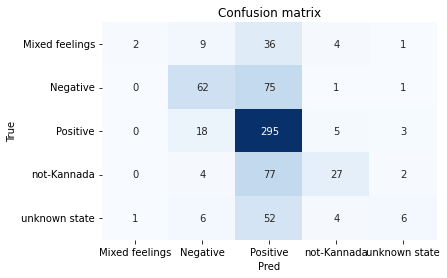

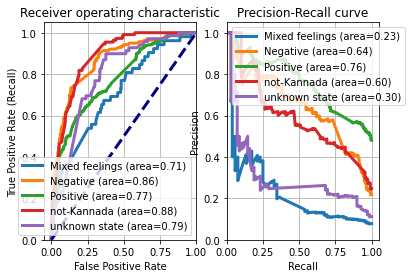

In [21]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()


In [22]:
#expolainer

## select observation
i = 1
txt_instance = test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Positive --> Pred: Positive | Prob: 0.89


/home/ubuntu/pyenv/lib/python3.6/site-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


# Training a cat boost classifier

In [25]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier(
    iterations=1500, 
    learning_rate=1, 
    #loss_function='CrossEntropy'
)


In [26]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

0:	learn: 1.4016719	total: 33.5ms	remaining: 50.3s
1:	learn: 1.3339359	total: 57.4ms	remaining: 43s
2:	learn: 1.3076466	total: 81.3ms	remaining: 40.5s
3:	learn: 1.2843804	total: 105ms	remaining: 39.2s
4:	learn: 1.2624397	total: 129ms	remaining: 38.4s
5:	learn: 1.2508378	total: 152ms	remaining: 37.8s
6:	learn: 1.2398855	total: 176ms	remaining: 37.5s
7:	learn: 1.2214680	total: 200ms	remaining: 37.3s
8:	learn: 1.2101472	total: 223ms	remaining: 37s
9:	learn: 1.1975268	total: 248ms	remaining: 36.9s
10:	learn: 1.1840271	total: 272ms	remaining: 36.8s
11:	learn: 1.1753470	total: 295ms	remaining: 36.6s
12:	learn: 1.1704125	total: 319ms	remaining: 36.5s
13:	learn: 1.1645335	total: 342ms	remaining: 36.3s
14:	learn: 1.1570292	total: 367ms	remaining: 36.3s
15:	learn: 1.1509059	total: 390ms	remaining: 36.2s
16:	learn: 1.1462952	total: 413ms	remaining: 36.1s
17:	learn: 1.1419769	total: 437ms	remaining: 36s
18:	learn: 1.1356412	total: 461ms	remaining: 35.9s
19:	learn: 1.1301187	total: 484ms	remaining:

162:	learn: 0.9184877	total: 3.89s	remaining: 31.9s
163:	learn: 0.9178465	total: 3.91s	remaining: 31.9s
164:	learn: 0.9166558	total: 3.94s	remaining: 31.8s
165:	learn: 0.9161581	total: 3.96s	remaining: 31.8s
166:	learn: 0.9149583	total: 3.98s	remaining: 31.8s
167:	learn: 0.9140811	total: 4.01s	remaining: 31.8s
168:	learn: 0.9128567	total: 4.03s	remaining: 31.8s
169:	learn: 0.9124560	total: 4.05s	remaining: 31.7s
170:	learn: 0.9118530	total: 4.08s	remaining: 31.7s
171:	learn: 0.9116205	total: 4.11s	remaining: 31.7s
172:	learn: 0.9110892	total: 4.13s	remaining: 31.7s
173:	learn: 0.9105913	total: 4.15s	remaining: 31.7s
174:	learn: 0.9094138	total: 4.18s	remaining: 31.6s
175:	learn: 0.9091013	total: 4.2s	remaining: 31.6s
176:	learn: 0.9075730	total: 4.22s	remaining: 31.6s
177:	learn: 0.9069791	total: 4.25s	remaining: 31.6s
178:	learn: 0.9066964	total: 4.27s	remaining: 31.5s
179:	learn: 0.9061570	total: 4.3s	remaining: 31.5s
180:	learn: 0.9053095	total: 4.32s	remaining: 31.5s
181:	learn: 0.

324:	learn: 0.8206521	total: 7.76s	remaining: 28.1s
325:	learn: 0.8203393	total: 7.79s	remaining: 28s
326:	learn: 0.8187344	total: 7.81s	remaining: 28s
327:	learn: 0.8183705	total: 7.83s	remaining: 28s
328:	learn: 0.8178939	total: 7.86s	remaining: 28s
329:	learn: 0.8173520	total: 7.88s	remaining: 27.9s
330:	learn: 0.8170154	total: 7.91s	remaining: 27.9s
331:	learn: 0.8158102	total: 7.93s	remaining: 27.9s
332:	learn: 0.8155395	total: 7.95s	remaining: 27.9s
333:	learn: 0.8152278	total: 7.98s	remaining: 27.9s
334:	learn: 0.8148797	total: 8s	remaining: 27.8s
335:	learn: 0.8144297	total: 8.03s	remaining: 27.8s
336:	learn: 0.8141833	total: 8.05s	remaining: 27.8s
337:	learn: 0.8138908	total: 8.07s	remaining: 27.8s
338:	learn: 0.8135245	total: 8.1s	remaining: 27.7s
339:	learn: 0.8133046	total: 8.12s	remaining: 27.7s
340:	learn: 0.8129153	total: 8.14s	remaining: 27.7s
341:	learn: 0.8122227	total: 8.17s	remaining: 27.7s
342:	learn: 0.8112926	total: 8.19s	remaining: 27.6s
343:	learn: 0.8110197	to

486:	learn: 0.7589638	total: 11.6s	remaining: 24.2s
487:	learn: 0.7587680	total: 11.7s	remaining: 24.2s
488:	learn: 0.7583709	total: 11.7s	remaining: 24.2s
489:	learn: 0.7578093	total: 11.7s	remaining: 24.1s
490:	learn: 0.7574663	total: 11.7s	remaining: 24.1s
491:	learn: 0.7571066	total: 11.8s	remaining: 24.1s
492:	learn: 0.7569631	total: 11.8s	remaining: 24.1s
493:	learn: 0.7567885	total: 11.8s	remaining: 24s
494:	learn: 0.7563701	total: 11.8s	remaining: 24s
495:	learn: 0.7562046	total: 11.8s	remaining: 24s
496:	learn: 0.7558489	total: 11.9s	remaining: 24s
497:	learn: 0.7556333	total: 11.9s	remaining: 23.9s
498:	learn: 0.7553826	total: 11.9s	remaining: 23.9s
499:	learn: 0.7552356	total: 11.9s	remaining: 23.9s
500:	learn: 0.7548898	total: 12s	remaining: 23.9s
501:	learn: 0.7547089	total: 12s	remaining: 23.8s
502:	learn: 0.7545594	total: 12s	remaining: 23.8s
503:	learn: 0.7543298	total: 12s	remaining: 23.8s
504:	learn: 0.7539177	total: 12.1s	remaining: 23.8s
505:	learn: 0.7537616	total:

648:	learn: 0.7200242	total: 15.5s	remaining: 20.3s
649:	learn: 0.7198598	total: 15.5s	remaining: 20.3s
650:	learn: 0.7195018	total: 15.6s	remaining: 20.3s
651:	learn: 0.7193458	total: 15.6s	remaining: 20.3s
652:	learn: 0.7191471	total: 15.6s	remaining: 20.2s
653:	learn: 0.7188970	total: 15.6s	remaining: 20.2s
654:	learn: 0.7187516	total: 15.6s	remaining: 20.2s
655:	learn: 0.7184684	total: 15.7s	remaining: 20.2s
656:	learn: 0.7181521	total: 15.7s	remaining: 20.1s
657:	learn: 0.7170472	total: 15.7s	remaining: 20.1s
658:	learn: 0.7168606	total: 15.7s	remaining: 20.1s
659:	learn: 0.7166957	total: 15.8s	remaining: 20.1s
660:	learn: 0.7163245	total: 15.8s	remaining: 20s
661:	learn: 0.7162075	total: 15.8s	remaining: 20s
662:	learn: 0.7160531	total: 15.8s	remaining: 20s
663:	learn: 0.7159135	total: 15.9s	remaining: 20s
664:	learn: 0.7157410	total: 15.9s	remaining: 19.9s
665:	learn: 0.7153717	total: 15.9s	remaining: 19.9s
666:	learn: 0.7152587	total: 15.9s	remaining: 19.9s
667:	learn: 0.715003

810:	learn: 0.6882946	total: 19.4s	remaining: 16.5s
811:	learn: 0.6881686	total: 19.4s	remaining: 16.5s
812:	learn: 0.6880332	total: 19.5s	remaining: 16.4s
813:	learn: 0.6879276	total: 19.5s	remaining: 16.4s
814:	learn: 0.6878355	total: 19.5s	remaining: 16.4s
815:	learn: 0.6876957	total: 19.5s	remaining: 16.4s
816:	learn: 0.6874729	total: 19.6s	remaining: 16.4s
817:	learn: 0.6872694	total: 19.6s	remaining: 16.3s
818:	learn: 0.6872240	total: 19.6s	remaining: 16.3s
819:	learn: 0.6871567	total: 19.6s	remaining: 16.3s
820:	learn: 0.6868232	total: 19.7s	remaining: 16.3s
821:	learn: 0.6866777	total: 19.7s	remaining: 16.2s
822:	learn: 0.6866346	total: 19.7s	remaining: 16.2s
823:	learn: 0.6865493	total: 19.7s	remaining: 16.2s
824:	learn: 0.6863835	total: 19.8s	remaining: 16.2s
825:	learn: 0.6862695	total: 19.8s	remaining: 16.1s
826:	learn: 0.6862061	total: 19.8s	remaining: 16.1s
827:	learn: 0.6860299	total: 19.8s	remaining: 16.1s
828:	learn: 0.6859405	total: 19.8s	remaining: 16.1s
829:	learn: 

972:	learn: 0.6676112	total: 23.3s	remaining: 12.6s
973:	learn: 0.6675676	total: 23.3s	remaining: 12.6s
974:	learn: 0.6674427	total: 23.3s	remaining: 12.6s
975:	learn: 0.6673023	total: 23.4s	remaining: 12.5s
976:	learn: 0.6672014	total: 23.4s	remaining: 12.5s
977:	learn: 0.6669895	total: 23.4s	remaining: 12.5s
978:	learn: 0.6668810	total: 23.4s	remaining: 12.5s
979:	learn: 0.6666973	total: 23.4s	remaining: 12.4s
980:	learn: 0.6665663	total: 23.5s	remaining: 12.4s
981:	learn: 0.6664946	total: 23.5s	remaining: 12.4s
982:	learn: 0.6664137	total: 23.5s	remaining: 12.4s
983:	learn: 0.6663607	total: 23.5s	remaining: 12.3s
984:	learn: 0.6662820	total: 23.6s	remaining: 12.3s
985:	learn: 0.6661725	total: 23.6s	remaining: 12.3s
986:	learn: 0.6661017	total: 23.6s	remaining: 12.3s
987:	learn: 0.6659147	total: 23.6s	remaining: 12.3s
988:	learn: 0.6658190	total: 23.7s	remaining: 12.2s
989:	learn: 0.6657229	total: 23.7s	remaining: 12.2s
990:	learn: 0.6656666	total: 23.7s	remaining: 12.2s
991:	learn: 

1134:	learn: 0.6526942	total: 27.1s	remaining: 8.73s
1135:	learn: 0.6526735	total: 27.2s	remaining: 8.71s
1136:	learn: 0.6526036	total: 27.2s	remaining: 8.68s
1137:	learn: 0.6525183	total: 27.2s	remaining: 8.66s
1138:	learn: 0.6524715	total: 27.2s	remaining: 8.63s
1139:	learn: 0.6524110	total: 27.3s	remaining: 8.61s
1140:	learn: 0.6523373	total: 27.3s	remaining: 8.59s
1141:	learn: 0.6521588	total: 27.3s	remaining: 8.56s
1142:	learn: 0.6520339	total: 27.3s	remaining: 8.54s
1143:	learn: 0.6518870	total: 27.4s	remaining: 8.52s
1144:	learn: 0.6518115	total: 27.4s	remaining: 8.49s
1145:	learn: 0.6517283	total: 27.4s	remaining: 8.47s
1146:	learn: 0.6517039	total: 27.4s	remaining: 8.44s
1147:	learn: 0.6516495	total: 27.5s	remaining: 8.42s
1148:	learn: 0.6515774	total: 27.5s	remaining: 8.39s
1149:	learn: 0.6515130	total: 27.5s	remaining: 8.37s
1150:	learn: 0.6510103	total: 27.5s	remaining: 8.35s
1151:	learn: 0.6509701	total: 27.6s	remaining: 8.32s
1152:	learn: 0.6509181	total: 27.6s	remaining:

1296:	learn: 0.6406229	total: 31s	remaining: 4.86s
1297:	learn: 0.6405326	total: 31.1s	remaining: 4.83s
1298:	learn: 0.6404886	total: 31.1s	remaining: 4.81s
1299:	learn: 0.6404429	total: 31.1s	remaining: 4.79s
1300:	learn: 0.6404351	total: 31.1s	remaining: 4.76s
1301:	learn: 0.6402566	total: 31.2s	remaining: 4.74s
1302:	learn: 0.6402089	total: 31.2s	remaining: 4.71s
1303:	learn: 0.6401032	total: 31.2s	remaining: 4.69s
1304:	learn: 0.6400254	total: 31.2s	remaining: 4.67s
1305:	learn: 0.6399648	total: 31.2s	remaining: 4.64s
1306:	learn: 0.6399073	total: 31.3s	remaining: 4.62s
1307:	learn: 0.6398599	total: 31.3s	remaining: 4.59s
1308:	learn: 0.6398312	total: 31.3s	remaining: 4.57s
1309:	learn: 0.6397820	total: 31.3s	remaining: 4.55s
1310:	learn: 0.6397446	total: 31.4s	remaining: 4.52s
1311:	learn: 0.6397120	total: 31.4s	remaining: 4.5s
1312:	learn: 0.6396783	total: 31.4s	remaining: 4.47s
1313:	learn: 0.6394880	total: 31.4s	remaining: 4.45s
1314:	learn: 0.6394568	total: 31.5s	remaining: 4.

1458:	learn: 0.6314498	total: 34.9s	remaining: 981ms
1459:	learn: 0.6314270	total: 34.9s	remaining: 957ms
1460:	learn: 0.6313906	total: 35s	remaining: 933ms
1461:	learn: 0.6313416	total: 35s	remaining: 909ms
1462:	learn: 0.6311854	total: 35s	remaining: 885ms
1463:	learn: 0.6311657	total: 35s	remaining: 862ms
1464:	learn: 0.6311378	total: 35.1s	remaining: 838ms
1465:	learn: 0.6310832	total: 35.1s	remaining: 814ms
1466:	learn: 0.6310671	total: 35.1s	remaining: 790ms
1467:	learn: 0.6310215	total: 35.1s	remaining: 766ms
1468:	learn: 0.6310131	total: 35.2s	remaining: 742ms
1469:	learn: 0.6309645	total: 35.2s	remaining: 718ms
1470:	learn: 0.6308877	total: 35.2s	remaining: 694ms
1471:	learn: 0.6308747	total: 35.2s	remaining: 670ms
1472:	learn: 0.6308614	total: 35.3s	remaining: 646ms
1473:	learn: 0.6308127	total: 35.3s	remaining: 622ms
1474:	learn: 0.6307868	total: 35.3s	remaining: 598ms
1475:	learn: 0.6307626	total: 35.3s	remaining: 574ms
1476:	learn: 0.6307136	total: 35.4s	remaining: 551ms
1

Accuracy: 0.57
Auc: 0.79
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.38      0.19      0.26        52
      Negative       0.61      0.48      0.54       139
      Positive       0.58      0.79      0.67       321
   not-Kannada       0.58      0.52      0.55       110
 unknown state       0.29      0.10      0.15        69

      accuracy                           0.57       691
     macro avg       0.49      0.42      0.43       691
  weighted avg       0.54      0.57      0.54       691



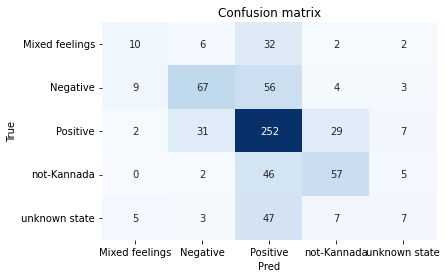

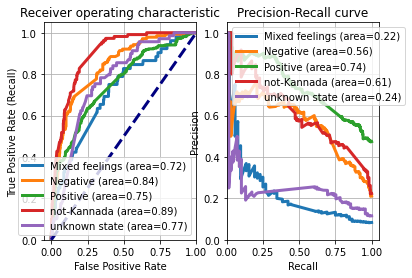

In [27]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=150, n_estimators=30, max_features=1331)

In [29]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.58
Auc: 0.78
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.50      0.13      0.21        52
      Negative       0.66      0.51      0.57       139
      Positive       0.58      0.82      0.68       321
   not-Kannada       0.58      0.50      0.54       110
 unknown state       0.25      0.07      0.11        69

      accuracy                           0.58       691
     macro avg       0.51      0.41      0.42       691
  weighted avg       0.56      0.58      0.54       691



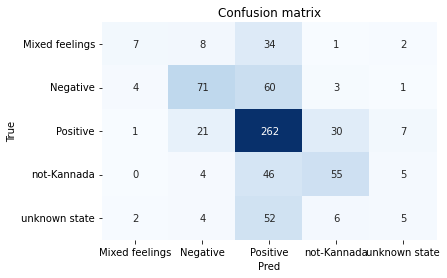

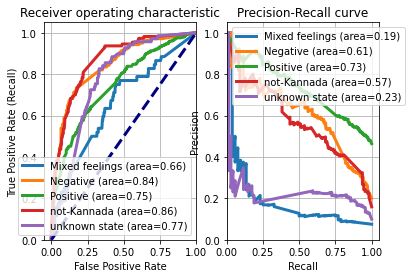

In [30]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [31]:
from sklearn.linear_model import LogisticRegression
classifier =LogisticRegression(random_state=0, max_iter= 200)

In [33]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.58
Auc: 0.81
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.50      0.08      0.13        52
      Negative       0.62      0.54      0.58       139
      Positive       0.58      0.84      0.69       321
   not-Kannada       0.63      0.37      0.47       110
 unknown state       0.36      0.14      0.21        69

      accuracy                           0.58       691
     macro avg       0.54      0.40      0.41       691
  weighted avg       0.57      0.58      0.54       691



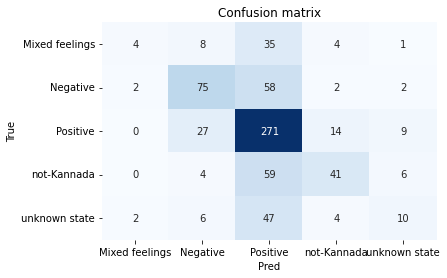

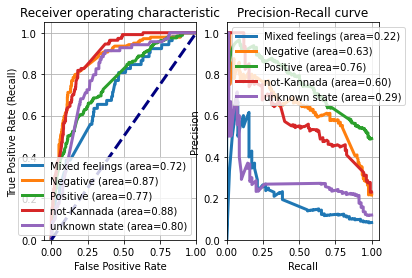

In [34]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [57]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=7, weights='distance')

In [58]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.56
Auc: 0.74
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.33      0.21      0.26        52
      Negative       0.66      0.42      0.51       139
      Positive       0.58      0.79      0.67       321
   not-Kannada       0.53      0.49      0.51       110
 unknown state       0.31      0.14      0.20        69

      accuracy                           0.56       691
     macro avg       0.48      0.41      0.43       691
  weighted avg       0.54      0.56      0.54       691



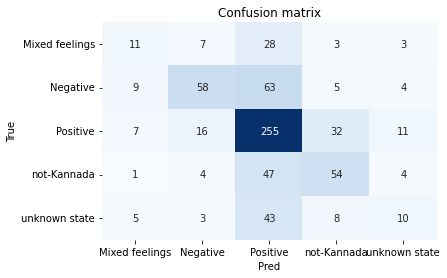

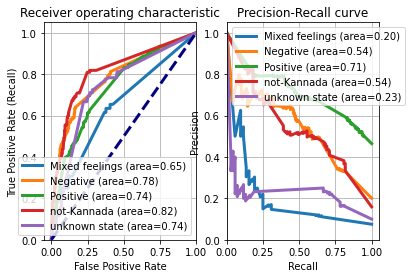

In [59]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()